## 1) Dynamical systems of some features

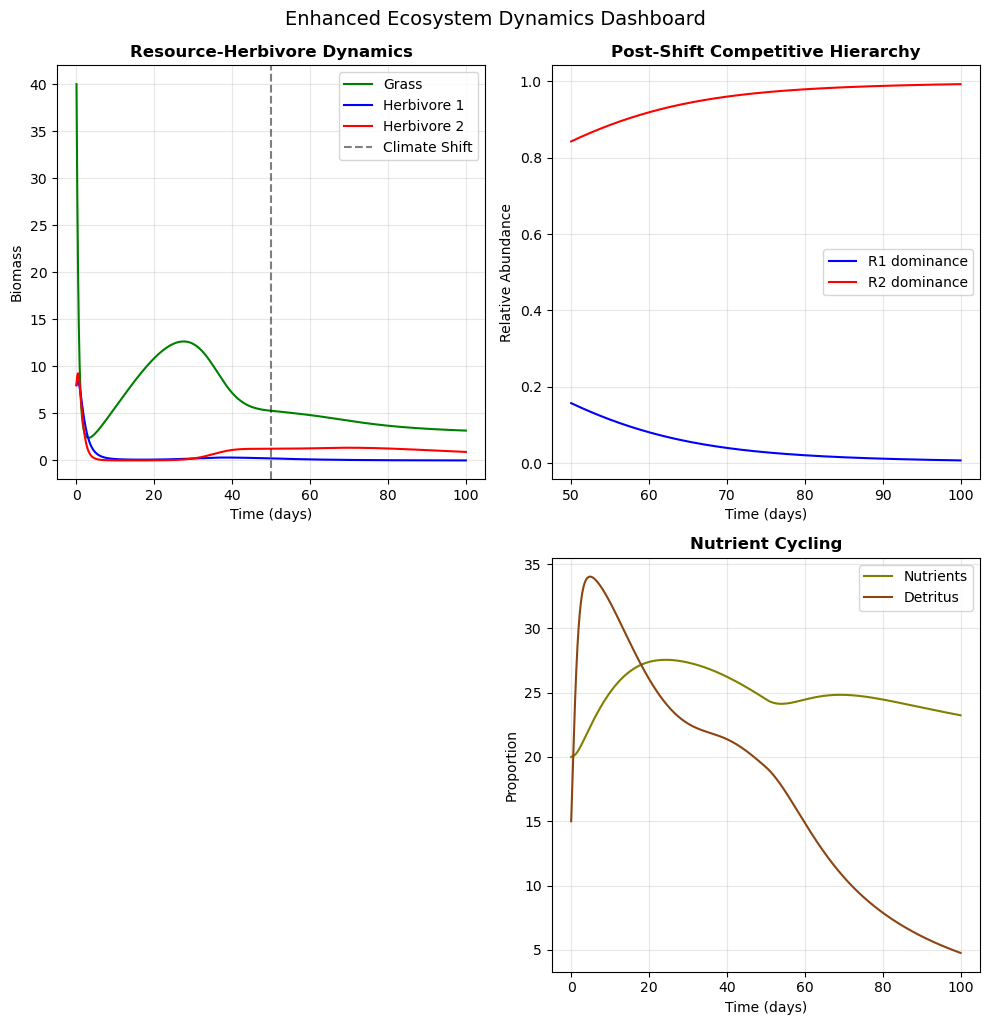

In [22]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from tqdm import tqdm  # For progress bars in sensitivity analysis

# ====== Adjusted Parameter Set ======
base_parameters = {
    # Grass growth (reduced alpha0 for more realistic growth)
    'alpha0': 0.05, 'KG': 100.0, 'beta_R1': 0.08, 'beta_R2': 0.12, 'beta_A': 0.03, 'mu_G': 0.01,
    
    # Herbivore dynamics (adjusted mortalities and conversion efficiencies)
    'gamma_R1': 0.25, 'gamma_R2': 0.35, 'm0': 0.01, 'm1': 0.03, 
    'mu_R1': 0.08, 'mu_R2': 0.12,  # Differential mortality
    
    # Predator/Omnivore dynamics (tuned predation rates)
    'delta_PR1': 0.08, 'delta_PR2': 0.15,  # Predator prefers R2
    'delta_AR1': 0.04, 'delta_AR2': 0.06,  # Omnivore prefers R2
    'gamma_P': 0.35, 'gamma_A': 0.45,  # Omnivore more efficient
    'mu_P': 0.06, 'mu_A': 0.04,
    
    # Top predator (lower impact)
    'delta_LP': 0.07, 'delta_LA': 0.05, 'gamma_L': 0.25, 'mu_L': 0.03,
    
    # Climate shift (stronger effect)
    'kappa': 0.02, 'tc': 50.0,
    
    # Nutrient cycling (slower)
    'eta': 0.05
}

# ====== Enhanced ODE System ======
def ecological_odes(t, y, params):
    G, R1, R2, P, A, L, N, D = y
    
    # Climate shift with stronger effect
    if t < params['tc']:
        alpha = params['alpha0']
        m = params['m0']
    else:
        alpha = params['alpha0'] * np.exp(-params['kappa'] * (t - params['tc']))
        m = -params['m1'] 
        
    # Modified grazing with carrying capacity effect
    grazing_R1 = params['beta_R1'] * G * R1 * (1 - 0.2*(R1+R2)/100)
    grazing_R2 = params['beta_R2'] * G * R2 * (1 - 0.2*(R1+R2)/100)
    
    dGdt = alpha * N * (1 - G/params['KG']) - grazing_R1 - grazing_R2 - params['beta_A'] * G * A - params['mu_G'] * G
    
    # Herbivores with density-dependent mortality
    dR1dt = (params['gamma_R1'] * grazing_R1 + m * R1 * R2 - 
             params['delta_PR1'] * P * R1 - params['delta_AR1'] * A * R1 - 
             params['mu_R1'] * R1 * (1 + 0.01*R1))
    
    dR2dt = (params['gamma_R2'] * grazing_R2 + m * R1 * R2 - 
             params['delta_PR2'] * P * R2 - params['delta_AR2'] * A * R2 - 
             params['mu_R2'] * R2 * (1 + 0.01*R2))
    
    # Predators with switching behavior
    total_prey = max(R1 + R2, 1e-6)
    dPdt = (params['gamma_P'] * (params['delta_PR1'] * P * R1**2/(R1+R2) + 
                                params['delta_PR2'] * P * R2**2/(R1+R2)) - 
            params['delta_LP'] * L * P - params['mu_P'] * P)
    
    dAdt = (params['gamma_A'] * (params['beta_A'] * G * A + 
                                params['delta_AR1'] * A * R1 + 
                                params['delta_AR2'] * A * R2) - 
            params['delta_LA'] * L * A - params['mu_A'] * A)
    
    dLdt = params['gamma_L'] * (params['delta_LP'] * L * P + params['delta_LA'] * L * A) - params['mu_L'] * L
    
    # Nutrient cycling with temperature dependence
    temp_effect = 1 + 0.5*np.tanh((t - params['tc'])/10) if t > params['tc'] else 1
    dNdt = params['eta'] * D * temp_effect - alpha * N * (1 - G/params['KG'])
    
    dDdt = (params['mu_G'] * G + params['mu_R1'] * R1 + params['mu_R2'] * R2 + 
            params['mu_P'] * P + params['mu_A'] * A + params['mu_L'] * L +
            (1 - params['gamma_P']) * (params['delta_PR1'] * P * R1 + params['delta_PR2'] * P * R2) +
            (1 - params['gamma_A']) * (params['beta_A'] * G * A + params['delta_AR1'] * A * R1 + params['delta_AR2'] * A * R2) +
            (1 - params['gamma_L']) * (params['delta_LP'] * L * P + params['delta_LA'] * L * A) -
            params['eta'] * D * temp_effect)
    
    return np.array([dGdt, dR1dt, dR2dt, dPdt, dAdt, dLdt, dNdt, dDdt])

# ====== RK4 Solver with Event Detection ======
def rk4_solver(y0, t_start, t_end, dt, params):
    num_steps = int((t_end - t_start) / dt)
    t_values = np.linspace(t_start, t_end, num_steps + 1)
    y_history = np.zeros((num_steps + 1, len(y0)))
    y_history[0] = y0
    
    for i in range(num_steps):
        t = t_values[i]
        y = y_history[i]
        k1 = ecological_odes(t, y, params)
        k2 = ecological_odes(t + dt/2, y + dt/2 * k1, params)
        k3 = ecological_odes(t + dt/2, y + dt/2 * k2, params)
        k4 = ecological_odes(t + dt, y + dt * k3, params)
        y_next = y + (dt / 6) * (k1 + 2*k2 + 2*k3 + k4)
        y_history[i+1] = np.maximum(y_next, 0)  # Prevent negative values
        
    return t_values, y_history

# ====== Sensitivity Analysis ======
def parameter_sensitivity(params, target_time=100, n_steps=20):
    """Analyze sensitivity of final populations to parameter changes"""
    parameters_to_test = ['alpha0', 'beta_R1', 'mu_R1', 'delta_PR1', 'gamma_P', 'kappa', 'm0', 'm1']
    results = {p: {'values': [], 'R1': [], 'R2': [], 'P': [], 'G': []} for p in parameters_to_test}
    
    base_values = {p: params[p] for p in parameters_to_test}
    
    for param in tqdm(parameters_to_test, desc='Sensitivity Analysis'):
        # Test ±50% of base value
        test_values = np.linspace(0.5*base_values[param], 1.5*base_values[param], n_steps)
        
        for val in test_values:
            test_params = params.copy()
            test_params[param] = val
            _, y = rk4_solver(y0, 0, target_time, 0.1, test_params)
            
            results[param]['values'].append(val)
            results[param]['R1'].append(y[-1, 1])  # Final R1
            results[param]['R2'].append(y[-1, 2])  # Final R2
            results[param]['P'].append(y[-1, 3])   # Final P
            results[param]['G'].append(y[-1, 0])   # Final Grass
    
    return results

# ====== Main Simulation ======
y0 = np.array([40.0, 8.0, 8.0, 4.0, 2.0, 1.0, 20.0, 15.0])  #  initial conditions
t, y = rk4_solver(y0, 0, 100, 0.1, base_parameters)
G, R1, R2, P, A, L, N, D = y.T

# ====== Enhanced Visualization ======

def plot_enhanced_dynamics(t, y, params):
    """All-in-one dashboard of ecosystem dynamics"""
    fig = plt.figure(figsize=(10, 10))
    gs = GridSpec(2, 2, figure=fig) 
    
    # Panel 1: Resource-Herbivore Dynamics
    ax1 = fig.add_subplot(gs[0, 0])
    ax1.plot(t, y[:, 0], 'g-', label='Grass')
    ax1.plot(t, y[:, 1], 'b-', label='Herbivore 1')
    ax1.plot(t, y[:, 2], 'r-', label='Herbivore 2')
    ax1.axvline(params['tc'], color='k', linestyle='--', alpha=0.5, label='Climate Shift')
    ax1.set_title('Resource-Herbivore Dynamics', fontweight='bold')
    ax1.set_ylabel('Biomass')
    ax1.set_xlabel('Time (days)')
    ax1.legend()
    ax1.grid(alpha=0.3)
    
    # Panel 2: Competitive Hierarchy
    ax2 = fig.add_subplot(gs[0, 1])
    post_shift = t >= params['tc']
    rel_R1 = y[post_shift, 1] / (y[post_shift, 1] + y[post_shift, 2] + 1e-6)
    rel_R2 = y[post_shift, 2] / (y[post_shift, 1] + y[post_shift, 2] + 1e-6)
    ax2.plot(t[post_shift], rel_R1, 'b-', label='R1 dominance')
    ax2.plot(t[post_shift], rel_R2, 'r-', label='R2 dominance')
    ax2.set_title('Post-Shift Competitive Hierarchy', fontweight='bold')
    ax2.set_ylabel('Relative Abundance')
    ax2.set_xlabel('Time (days)')
    ax2.legend()
    ax2.grid(alpha=0.3)
    
    
    # Panel 4: Nutrient Cycling (now moved to position [1,1])
    ax4 = fig.add_subplot(gs[1, 1])
    ax4.plot(t, y[:, 6], 'olive', label='Nutrients')
    ax4.plot(t, y[:, 7], 'saddlebrown', label='Detritus')
    ax4.set_title('Nutrient Cycling', fontweight='bold')
    ax4.set_ylabel('Proportion') 
    ax4.set_xlabel('Time (days)')
    ax4.legend()
    ax4.grid(alpha=0.3)
    
    plt.tight_layout()
    plt.suptitle('Enhanced Ecosystem Dynamics Dashboard', y=1.02, fontsize=14)
    plt.show() 
#====== Run Analysis ======
plot_enhanced_dynamics(t, y, base_parameters) 


## 2) Global Ecosystem Biomass and Sensitivity Analysis Evaluation

Running base simulation...

Plotting global biomass dynamics...


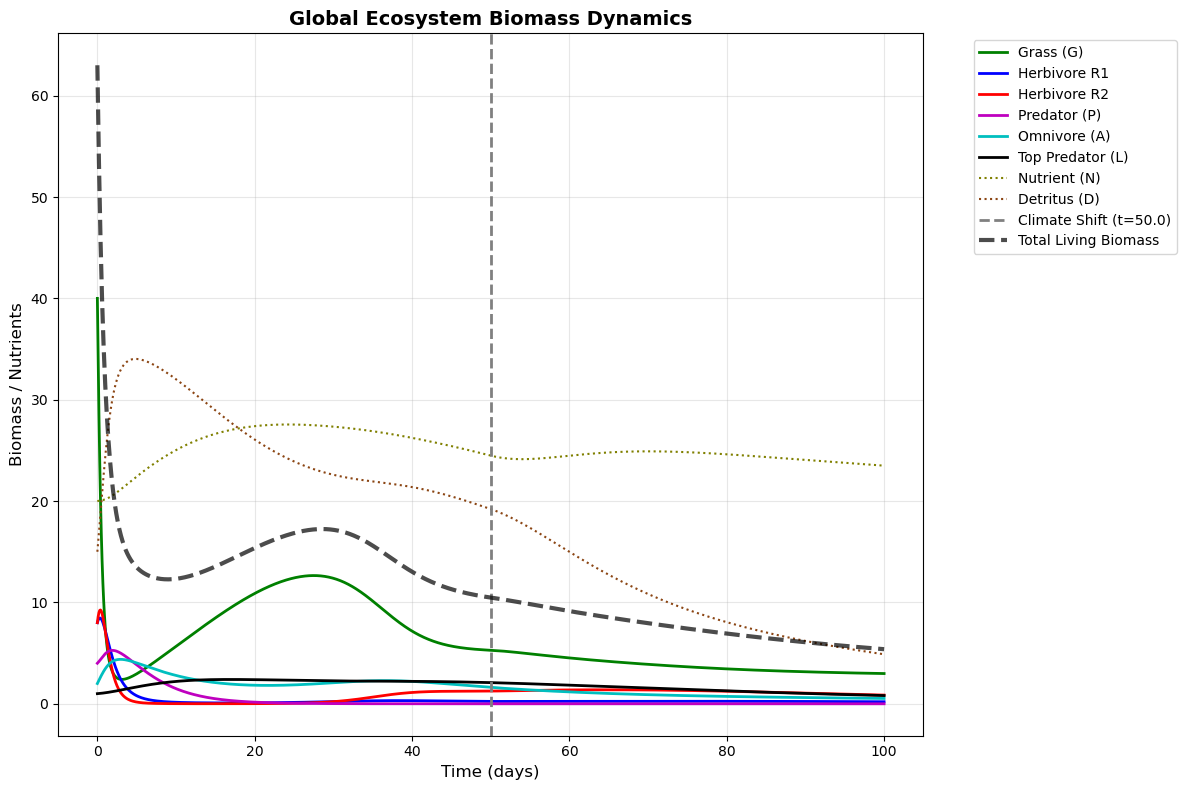


Running biomass sensitivity analysis (this may take a minute)...


Biomass Sensitivity: 100%|██████████████████████| 11/11 [00:09<00:00,  1.18it/s]



Plotting sensitivity scenarios...


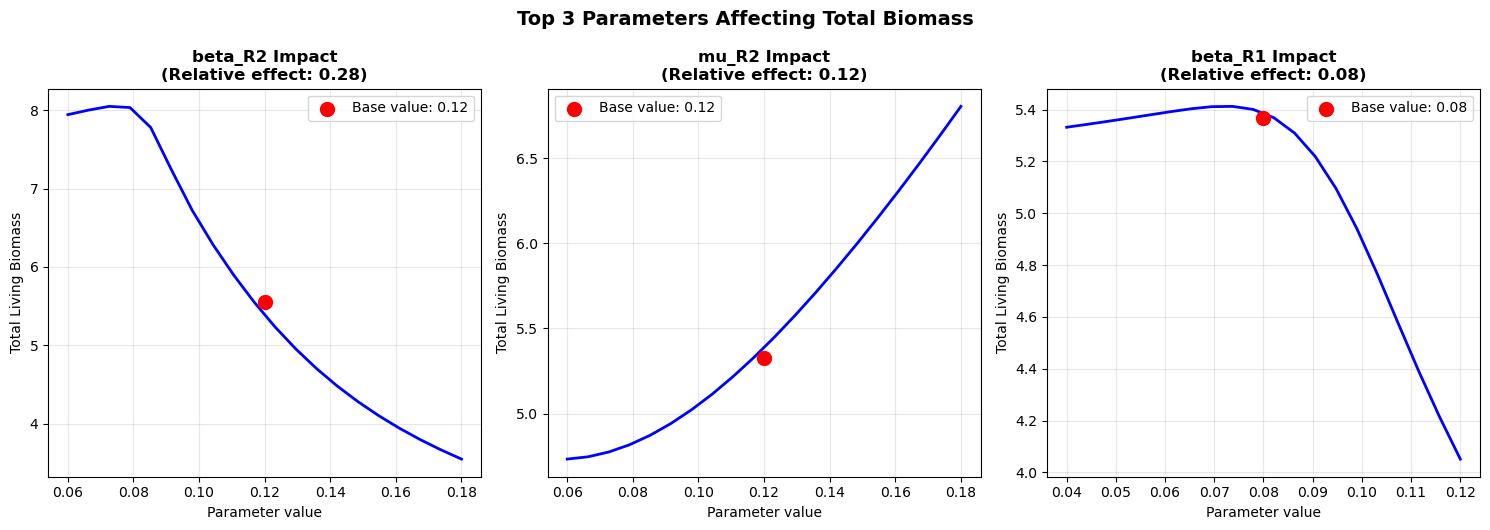


Analyzing component breakdown...

Analysis complete!


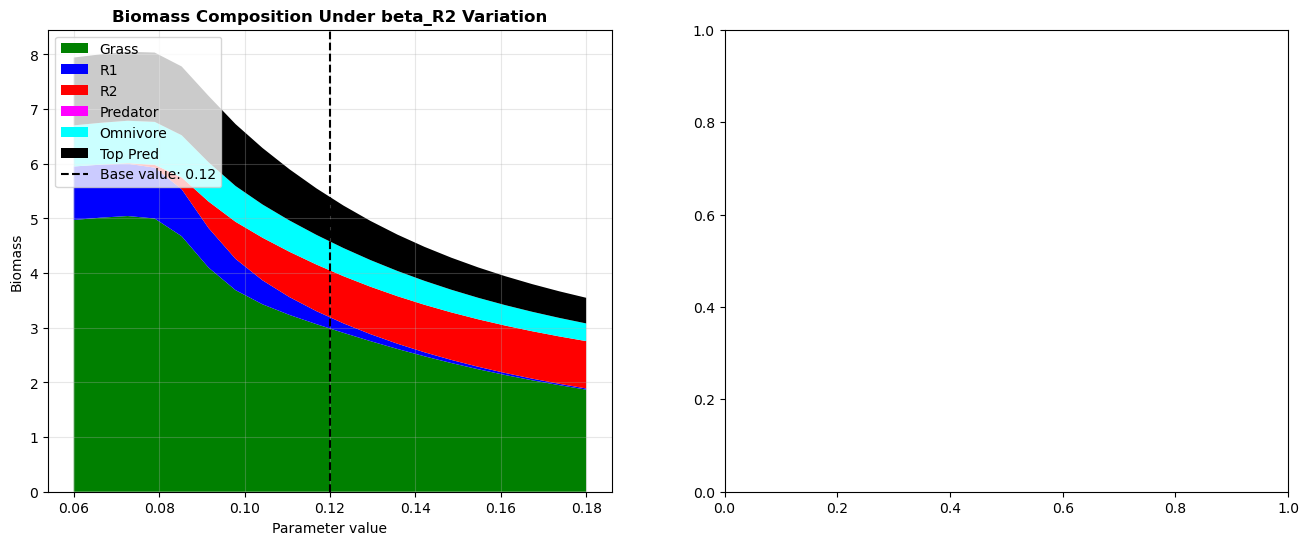

In [20]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm  # For progress bars

# ====== Adjusted Parameter Set ======
base_parameters = {
    # Grass growth (reduced alpha0 for more realistic growth)
    'alpha0': 0.05, 'KG': 100.0, 'beta_R1': 0.08, 'beta_R2': 0.12, 'beta_A': 0.03, 'mu_G': 0.01,
    
    # Herbivore dynamics (adjusted mortalities and conversion efficiencies)
    'gamma_R1': 0.25, 'gamma_R2': 0.35, 'm0': 0.01, 'm1': 0.03, 
    'mu_R1': 0.08, 'mu_R2': 0.12,  # Differential mortality
    
    # Predator/Omnivore dynamics (tuned predation rates)
    'delta_PR1': 0.08, 'delta_PR2': 0.15,  # Predator prefers R2
    'delta_AR1': 0.04, 'delta_AR2': 0.06,  # Omnivore prefers R2
    'gamma_P': 0.35, 'gamma_A': 0.45,  # Omnivore more efficient
    'mu_P': 0.06, 'mu_A': 0.04,
    
    # Top predator (lower impact)
    'delta_LP': 0.07, 'delta_LA': 0.05, 'gamma_L': 0.25, 'mu_L': 0.03,
    
    # Climate shift (stronger effect)
    'kappa': 0.02, 'tc': 50.0,
    
    # Nutrient cycling (slower)
    'eta': 0.05
}

# ====== Enhanced ODE System ======
def ecological_odes(t, y, params):
    G, R1, R2, P, A, L, N, D = y
    
    # Climate shift with stronger effect
    if t < params['tc']:
        alpha = params['alpha0']
        m = params['m0']
    else:
        alpha = params['alpha0'] * np.exp(-params['kappa'] * (t - params['tc']))
        m = params['m1'] 
        
    # Modified grazing with carrying capacity effect
    grazing_R1 = params['beta_R1'] * G * R1 * (1 - 0.2*(R1+R2)/100)
    grazing_R2 = params['beta_R2'] * G * R2 * (1 - 0.2*(R1+R2)/100)
    
    dGdt = alpha * N * (1 - G/params['KG']) - grazing_R1 - grazing_R2 - params['beta_A'] * G * A - params['mu_G'] * G
    
    # Herbivores with density-dependent mortality
    dR1dt = (params['gamma_R1'] * grazing_R1 + m * R1 * R2 - 
             params['delta_PR1'] * P * R1 - params['delta_AR1'] * A * R1 - 
             params['mu_R1'] * R1 * (1 + 0.01*R1))
    
    dR2dt = (params['gamma_R2'] * grazing_R2 + m * R1 * R2 - 
             params['delta_PR2'] * P * R2 - params['delta_AR2'] * A * R2 - 
             params['mu_R2'] * R2 * (1 + 0.01*R2))
    
    # Predators with switching behavior
    total_prey = max(R1 + R2, 1e-6)
    dPdt = (params['gamma_P'] * (params['delta_PR1'] * P * R1**2/(R1+R2) + 
                                params['delta_PR2'] * P * R2**2/(R1+R2)) - 
            params['delta_LP'] * L * P - params['mu_P'] * P)
    
    dAdt = (params['gamma_A'] * (params['beta_A'] * G * A + 
                                params['delta_AR1'] * A * R1 + 
                                params['delta_AR2'] * A * R2) - 
            params['delta_LA'] * L * A - params['mu_A'] * A)
    
    dLdt = params['gamma_L'] * (params['delta_LP'] * L * P + params['delta_LA'] * L * A) - params['mu_L'] * L
    
    # Nutrient cycling with temperature dependence
    temp_effect = 1 + 0.5*np.tanh((t - params['tc'])/10) if t > params['tc'] else 1
    dNdt = params['eta'] * D * temp_effect - alpha * N * (1 - G/params['KG'])
    
    dDdt = (params['mu_G'] * G + params['mu_R1'] * R1 + params['mu_R2'] * R2 + 
            params['mu_P'] * P + params['mu_A'] * A + params['mu_L'] * L +
            (1 - params['gamma_P']) * (params['delta_PR1'] * P * R1 + params['delta_PR2'] * P * R2) +
            (1 - params['gamma_A']) * (params['beta_A'] * G * A + params['delta_AR1'] * A * R1 + params['delta_AR2'] * A * R2) +
            (1 - params['gamma_L']) * (params['delta_LP'] * L * P + params['delta_LA'] * L * A) -
            params['eta'] * D * temp_effect)
    
    return np.array([dGdt, dR1dt, dR2dt, dPdt, dAdt, dLdt, dNdt, dDdt])

# ====== RK4 Solver ======
def rk4_solver(y0, t_start, t_end, dt, params):
    num_steps = int((t_end - t_start) / dt)
    t_values = np.linspace(t_start, t_end, num_steps + 1)
    y_history = np.zeros((num_steps + 1, len(y0)))
    y_history[0] = y0
    
    for i in range(num_steps):
        t = t_values[i]
        y = y_history[i]
        k1 = ecological_odes(t, y, params)
        k2 = ecological_odes(t + dt/2, y + dt/2 * k1, params)
        k3 = ecological_odes(t + dt/2, y + dt/2 * k2, params)
        k4 = ecological_odes(t + dt, y + dt * k3, params)
        y_next = y + (dt / 6) * (k1 + 2*k2 + 2*k3 + k4)
        y_history[i+1] = np.maximum(y_next, 0)  # Prevent negative values
        
    return t_values, y_history

# ====== Global Biomass Plot ======
def plot_global_biomass(t, y, params):
    """Plot all biomass components together with climate shift marker"""
    plt.figure(figsize=(12, 8))
    
    # Plot each component with distinct colors
    plt.plot(t, y[:, 0], 'g-', label='Grass (G)', linewidth=2)
    plt.plot(t, y[:, 1], 'b-', label='Herbivore R1', linewidth=2)
    plt.plot(t, y[:, 2], 'r-', label='Herbivore R2', linewidth=2)
    plt.plot(t, y[:, 3], 'm-', label='Predator (P)', linewidth=2)
    plt.plot(t, y[:, 4], 'c-', label='Omnivore (A)', linewidth=2)
    plt.plot(t, y[:, 5], 'k-', label='Top Predator (L)', linewidth=2)
    plt.plot(t, y[:, 6], 'olive', linestyle=':', label='Nutrient (N)', linewidth=1.5)
    plt.plot(t, y[:, 7], 'saddlebrown', linestyle=':', label='Detritus (D)', linewidth=1.5)
    
    # Add climate shift line and labels
    plt.axvline(x=params['tc'], color='gray', linestyle='--', linewidth=2, 
               label=f'Climate Shift (t={params["tc"]})')
    
    # Add total biomass line
    total_biomass = y[:, :6].sum(axis=1)  # Sum of living components
    plt.plot(t, total_biomass, 'k--', alpha=0.7, linewidth=3, label='Total Living Biomass')
    
    plt.title('Global Ecosystem Biomass Dynamics', fontsize=14, fontweight='bold')
    plt.xlabel('Time (days)', fontsize=12)
    plt.ylabel('Biomass / Nutrients', fontsize=12)
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()

# ====== Biomass Sensitivity Analysis ======
def biomass_sensitivity(params, target_time=100, n_steps=20):
    """Analyze sensitivity of total biomass to parameter changes"""
    parameters_to_test = ['alpha0', 'beta_R1', 'beta_R2', 'mu_R1', 'mu_R2', 
                        'delta_PR1', 'delta_PR2', 'gamma_P', 'kappa', 'm0', 'm1']
    results = {p: {'values': [], 'total_biomass': [], 'components': []} for p in parameters_to_test}
    
    base_values = {p: params[p] for p in parameters_to_test}
    
    for param in tqdm(parameters_to_test, desc='Biomass Sensitivity'):
        test_values = np.linspace(0.5*base_values[param], 1.5*base_values[param], n_steps)
        
        for val in test_values:
            test_params = params.copy()
            test_params[param] = val
            _, y = rk4_solver(y0, 0, target_time, 0.1, test_params)
            
            # Calculate total living biomass (excluding nutrients/detritus)
            living_biomass = y[-1, :6].sum()
            
            results[param]['values'].append(val)
            results[param]['total_biomass'].append(living_biomass)
            results[param]['components'].append(y[-1, :6])  # Store final component values
    
    return results

# ====== Scenario Comparison ======
def plot_biomass_scenarios(sensitivity_results, params):
    """Plot biomass responses for different parameter scenarios"""
    # Identify most sensitive parameters
    param_impacts = []
    for param in sensitivity_results:
        impact = np.std(sensitivity_results[param]['total_biomass']) / np.mean(sensitivity_results[param]['total_biomass'])
        param_impacts.append((param, impact))
    
    # Sort by impact and take top 3
    top_params = sorted(param_impacts, key=lambda x: x[1], reverse=True)[:3]
    
    # Create figure
    plt.figure(figsize=(15, 5))
    
    # Plot each parameter scenario
    for i, (param, impact) in enumerate(top_params):
        plt.subplot(1, 3, i+1)
        
        # Plot biomass response curve
        values = np.array(sensitivity_results[param]['values'])  # Convert to numpy array
        biomass = sensitivity_results[param]['total_biomass']
        plt.plot(values, biomass, 'b-', linewidth=2)
        
        # Mark base value
        base_val = params[param]
        base_idx = np.argmin(np.abs(values - base_val))
        plt.scatter(base_val, biomass[base_idx], c='r', s=100, zorder=5, 
                   label=f'Base value: {base_val:.2f}')
        
        plt.title(f'{param} Impact\n(Relative effect: {impact:.2f})', fontweight='bold')
        plt.xlabel('Parameter value', fontsize=10)
        plt.ylabel('Total Living Biomass', fontsize=10)
        plt.legend()
        plt.grid(alpha=0.3)
    
    plt.tight_layout()
    plt.suptitle('Top 3 Parameters Affecting Total Biomass', y=1.05, fontsize=14, fontweight='bold')
    plt.show() 

# ====== Component Breakdown ======
def plot_component_breakdown(sensitivity_results, params):
    """Show how parameter changes affect different components"""
    # Get most influential parameter
    most_influential = max(
        [(param, np.std(sensitivity_results[param]['total_biomass'])) 
         for param in sensitivity_results],
        key=lambda x: x[1]
    )[0]
    
    # Prepare data
    values = sensitivity_results[most_influential]['values']
    components = np.array(sensitivity_results[most_influential]['components'])
    component_names = ['Grass', 'R1', 'R2', 'Predator', 'Omnivore', 'Top Pred']
    colors = ['green', 'blue', 'red', 'magenta', 'cyan', 'black']
    
    # Create figure
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
    
    # Panel 1: Stacked area plot
    ax1.stackplot(values, components.T, labels=component_names, colors=colors)
    ax1.axvline(params[most_influential], color='k', linestyle='--', 
               label=f'Base value: {params[most_influential]:.2f}')
    ax1.set_title(f'Biomass Composition Under {most_influential} Variation', fontweight='bold')
    ax1.set_xlabel('Parameter value')
    ax1.set_ylabel('Biomass')
    ax1.legend(loc='upper left')
    ax1.grid(alpha=0.3)

# ====== Main Execution ======
if __name__ == "__main__":
    # Initial conditions
    y0 = np.array([40.0, 8.0, 8.0, 4.0, 2.0, 1.0, 20.0, 15.0])
    
    # 1. Run base simulation
    print("Running base simulation...")
    t, y = rk4_solver(y0, 0, 100, 0.1, base_parameters)
    
    # 2. Plot global biomass dynamics
    print("\nPlotting global biomass dynamics...")
    plot_global_biomass(t, y, base_parameters)
    
    # 3. Perform sensitivity analysis
    print("\nRunning biomass sensitivity analysis (this may take a minute)...")
    biomass_results = biomass_sensitivity(base_parameters)
    
    # 4. Plot scenario comparisons
    print("\nPlotting sensitivity scenarios...")
    plot_biomass_scenarios(biomass_results, base_parameters)
    
    # 5. Show component breakdown
    print("\nAnalyzing component breakdown...")
    plot_component_breakdown(biomass_results, base_parameters)
    
    print("\nAnalysis complete!")

### Output Comment

#### a) Beta_R2 impact

Total Biomass represents the combined mass of all living organisms (grass, herbivores, etc.) in the ecosystem.

Increasing beta_R2 means R2 herbivores graze more aggressively, consuming grass faster.

Overgrazing leads to grass depletion, triggering a chain reaction that reduces food availability and crashes populations.

As a result, higher beta_R2 reduces total biomass and destabilizes the entire ecosystem.

SImilar Observations can be done for the others parameters

## 3) Evaluation the climate stress coeffiient (k) and interaction strength (m1)

Running base simulation...

Running biomass sensitivity analysis...


Biomass Sensitivity: 100%|█████████████████████████████████| 11/11 [00:09<00:00,  1.21it/s]


Plotting selected parameter impact (kappa & m1)...


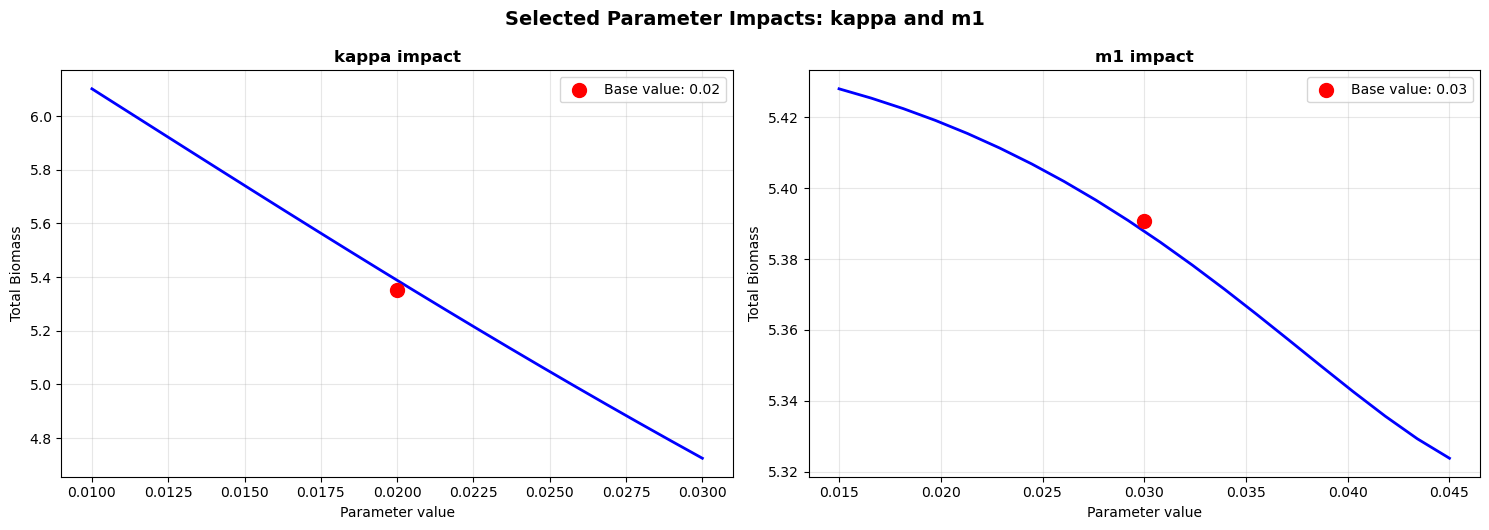


Done.


In [11]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

# ====== Adjusted Parameter Set ======
base_parameters = {
    'alpha0': 0.05, 'KG': 100.0, 'beta_R1': 0.08, 'beta_R2': 0.12, 'beta_A': 0.03, 'mu_G': 0.01,
    'gamma_R1': 0.25, 'gamma_R2': 0.35, 'm0': 0.01, 'm1': 0.03,
    'mu_R1': 0.08, 'mu_R2': 0.12,
    'delta_PR1': 0.08, 'delta_PR2': 0.15,
    'delta_AR1': 0.04, 'delta_AR2': 0.06,
    'gamma_P': 0.35, 'gamma_A': 0.45,
    'mu_P': 0.06, 'mu_A': 0.04,
    'delta_LP': 0.07, 'delta_LA': 0.05, 'gamma_L': 0.25, 'mu_L': 0.03,
    'kappa': 0.02, 'tc': 50.0,
    'eta': 0.05
}

# ====== ODEs ======
def ecological_odes(t, y, params):
    G, R1, R2, P, A, L, N, D = y

    if t < params['tc']:
        alpha = params['alpha0']
        m = params['m0']
    else:
        alpha = params['alpha0'] * np.exp(-params['kappa'] * (t - params['tc']))
        m = params['m1']

    grazing_R1 = params['beta_R1'] * G * R1 * (1 - 0.2*(R1+R2)/100)
    grazing_R2 = params['beta_R2'] * G * R2 * (1 - 0.2*(R1+R2)/100)

    dGdt = alpha * N * (1 - G/params['KG']) - grazing_R1 - grazing_R2 - params['beta_A'] * G * A - params['mu_G'] * G

    dR1dt = (params['gamma_R1'] * grazing_R1 + m * R1 * R2 -
             params['delta_PR1'] * P * R1 - params['delta_AR1'] * A * R1 -
             params['mu_R1'] * R1 * (1 + 0.01*R1))

    dR2dt = (params['gamma_R2'] * grazing_R2 + m * R1 * R2 -
             params['delta_PR2'] * P * R2 - params['delta_AR2'] * A * R2 -
             params['mu_R2'] * R2 * (1 + 0.01*R2))

    total_prey = max(R1 + R2, 1e-6)
    dPdt = (params['gamma_P'] * (params['delta_PR1'] * P * R1**2 / total_prey +
                                 params['delta_PR2'] * P * R2**2 / total_prey) -
            params['delta_LP'] * L * P - params['mu_P'] * P)

    dAdt = (params['gamma_A'] * (params['beta_A'] * G * A +
                                 params['delta_AR1'] * A * R1 +
                                 params['delta_AR2'] * A * R2) -
            params['delta_LA'] * L * A - params['mu_A'] * A)

    dLdt = params['gamma_L'] * (params['delta_LP'] * L * P + params['delta_LA'] * L * A) - params['mu_L'] * L

    temp_effect = 1 + 0.5 * np.tanh((t - params['tc']) / 10) if t > params['tc'] else 1
    dNdt = params['eta'] * D * temp_effect - alpha * N * (1 - G / params['KG'])

    dDdt = (params['mu_G'] * G + params['mu_R1'] * R1 + params['mu_R2'] * R2 +
            params['mu_P'] * P + params['mu_A'] * A + params['mu_L'] * L +
            (1 - params['gamma_P']) * (params['delta_PR1'] * P * R1 + params['delta_PR2'] * P * R2) +
            (1 - params['gamma_A']) * (params['beta_A'] * G * A + params['delta_AR1'] * A * R1 + params['delta_AR2'] * A * R2) +
            (1 - params['gamma_L']) * (params['delta_LP'] * L * P + params['delta_LA'] * L * A) -
            params['eta'] * D * temp_effect)

    return np.array([dGdt, dR1dt, dR2dt, dPdt, dAdt, dLdt, dNdt, dDdt])

# ====== RK4 Solver ======
def rk4_solver(y0, t_start, t_end, dt, params):
    num_steps = int((t_end - t_start) / dt)
    t_values = np.linspace(t_start, t_end, num_steps + 1)
    y_history = np.zeros((num_steps + 1, len(y0)))
    y_history[0] = y0

    for i in range(num_steps):
        t = t_values[i]
        y = y_history[i]
        k1 = ecological_odes(t, y, params)
        k2 = ecological_odes(t + dt/2, y + dt/2 * k1, params)
        k3 = ecological_odes(t + dt/2, y + dt/2 * k2, params)
        k4 = ecological_odes(t + dt, y + dt * k3, params)
        y_next = y + (dt / 6) * (k1 + 2*k2 + 2*k3 + k4)
        y_history[i+1] = np.maximum(y_next, 0)

    return t_values, y_history

# ====== Biomass Sensitivity Analysis ======
def biomass_sensitivity(params, target_time=100, n_steps=20):
    parameters_to_test = ['alpha0', 'beta_R1', 'beta_R2', 'mu_R1', 'mu_R2',
                          'delta_PR1', 'delta_PR2', 'gamma_P', 'kappa', 'm0', 'm1']
    results = {p: {'values': [], 'total_biomass': [], 'components': []} for p in parameters_to_test}
    base_values = {p: params[p] for p in parameters_to_test}

    for param in tqdm(parameters_to_test, desc='Biomass Sensitivity'):
        test_values = np.linspace(0.5 * base_values[param], 1.5 * base_values[param], n_steps)
        for val in test_values:
            test_params = params.copy()
            test_params[param] = val
            _, y = rk4_solver(y0, 0, target_time, 0.1, test_params)
            living_biomass = y[-1, :6].sum()
            results[param]['values'].append(val)
            results[param]['total_biomass'].append(living_biomass)
            results[param]['components'].append(y[-1, :6])
    return results

# ====== New Plot for Specific Parameter Effects ======
def plot_selected_parameter_impact(sensitivity_results, params, selected_params):
    plt.figure(figsize=(15, 5))
    for i, param in enumerate(selected_params):
        plt.subplot(1, len(selected_params), i + 1)
        values = np.array(sensitivity_results[param]['values'])
        biomass = sensitivity_results[param]['total_biomass']
        plt.plot(values, biomass, 'b-', linewidth=2)
        base_val = params[param]
        base_idx = np.argmin(np.abs(values - base_val))
        plt.scatter(base_val, biomass[base_idx], c='r', s=100, zorder=5,
                    label=f'Base value: {base_val:.2f}')
        plt.title(f'{param} impact', fontweight='bold')
        plt.xlabel('Parameter value')
        plt.ylabel('Total Biomass')
        plt.legend()
        plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.suptitle('Selected Parameter Impacts: kappa and m1', y=1.05, fontsize=14, fontweight='bold')
    plt.show()

# ====== Main ======
if __name__ == "__main__":
    y0 = np.array([40.0, 8.0, 8.0, 4.0, 2.0, 1.0, 20.0, 15.0])
    
    print("Running base simulation...")
    t, y = rk4_solver(y0, 0, 100, 0.1, base_parameters)

    print("\nRunning biomass sensitivity analysis...")
    biomass_results = biomass_sensitivity(base_parameters)

    print("\nPlotting selected parameter impact (kappa & m1)...")
    plot_selected_parameter_impact(biomass_results, base_parameters, ['kappa', 'm1'])

    print("\nDone.")
